In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from lateral_connections import LateralModel, VggModel, CustomImageDataset

model_path = 'models/VGG19_normalized_avg_pool_pytorch'
vm = VggModel(model_path, torch.device('cuda'), important_layers=['relu1_1', 'pool1', 'pool2'])

model = LateralModel(vgg_model=vm, distance=2, num_output_repetitions=4, horizon_length=512)

def torch_transform(img):
    return img.reshape((1,) + img.shape).float()

ds = CustomImageDataset('images/geometric_dataset/annotations.csv', image_transform=torch_transform)



In [2]:
pbar = tqdm(range(2))
for i in pbar:
    img_id = np.random.randint(len(ds))
    img, label = ds[img_id]
    pbar.set_description(f"Processing #{img_id} ({ds.labels[label]})")
    
    model.forward(img)

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
model.save_model('blub.h5')

Saved model to blub.h5 successfully.


In [4]:
K = torch.clone(model.K)
H = torch.clone(model.H)

model.load_model('blub.h5')

print((K == model.K).all())
print((H == model.H).all())
print(model.iterations_trained)

Loaded model from blub.h5 successfully.	(2 train iterations detected.)
	The following config was used:
	d: 2, k: 5, h: 512, mu: 0.005, alpha: 0.1
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
2


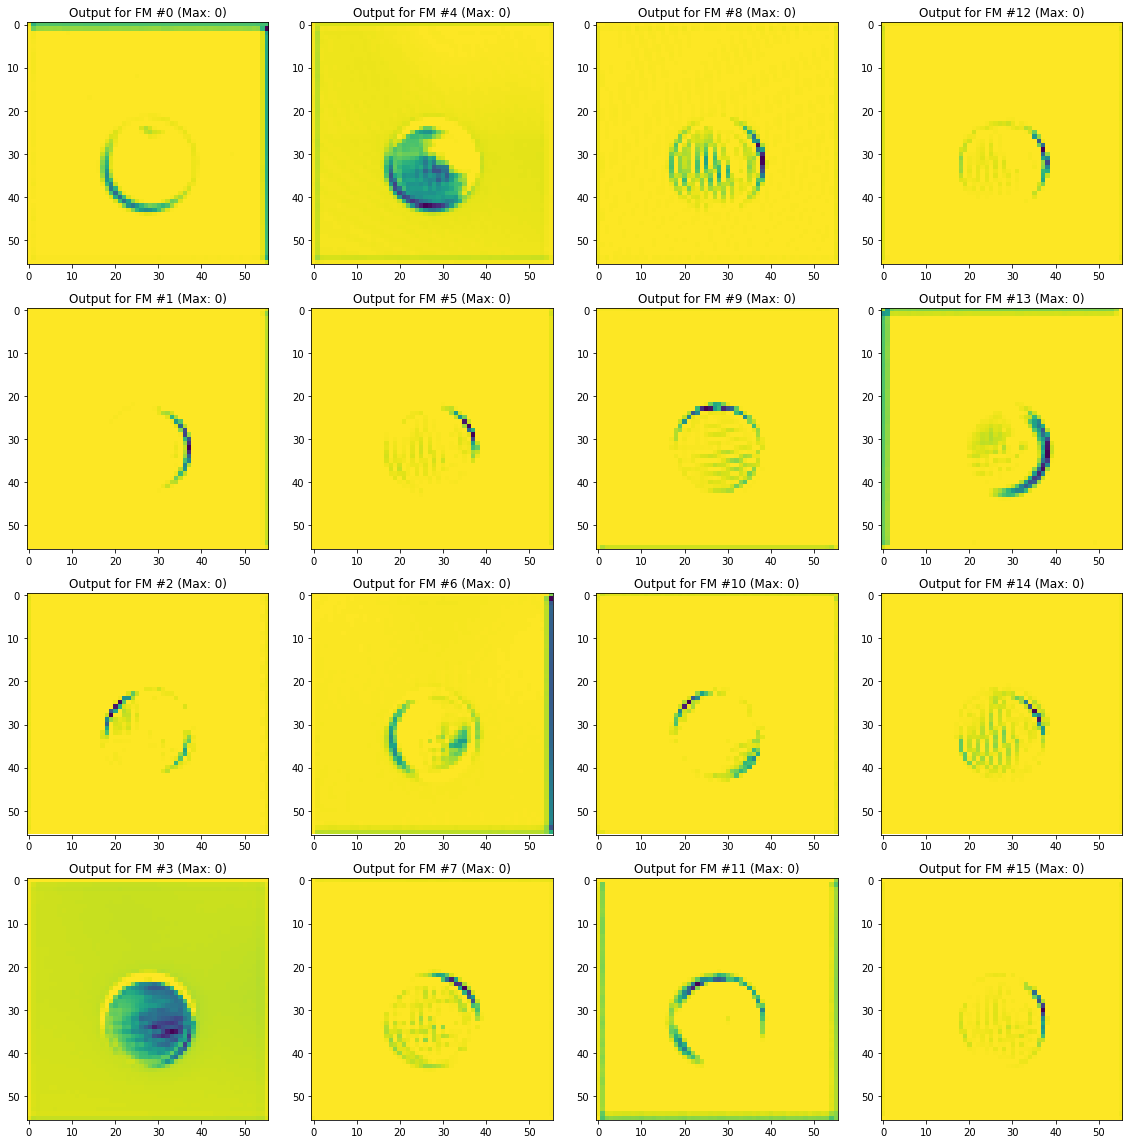

In [3]:
fig, axs = plt.subplots(4,4,figsize=(16,16))

for i in range(4):
    for j in range(4):
        axs[i,j].imshow(model.O[i+4*j, :, :])
        axs[i,j].set_title(f"Output for FM #{i+4*j} (Max: {int(np.max(model.O[i+4*j,:,:]))})")
plt.tight_layout()

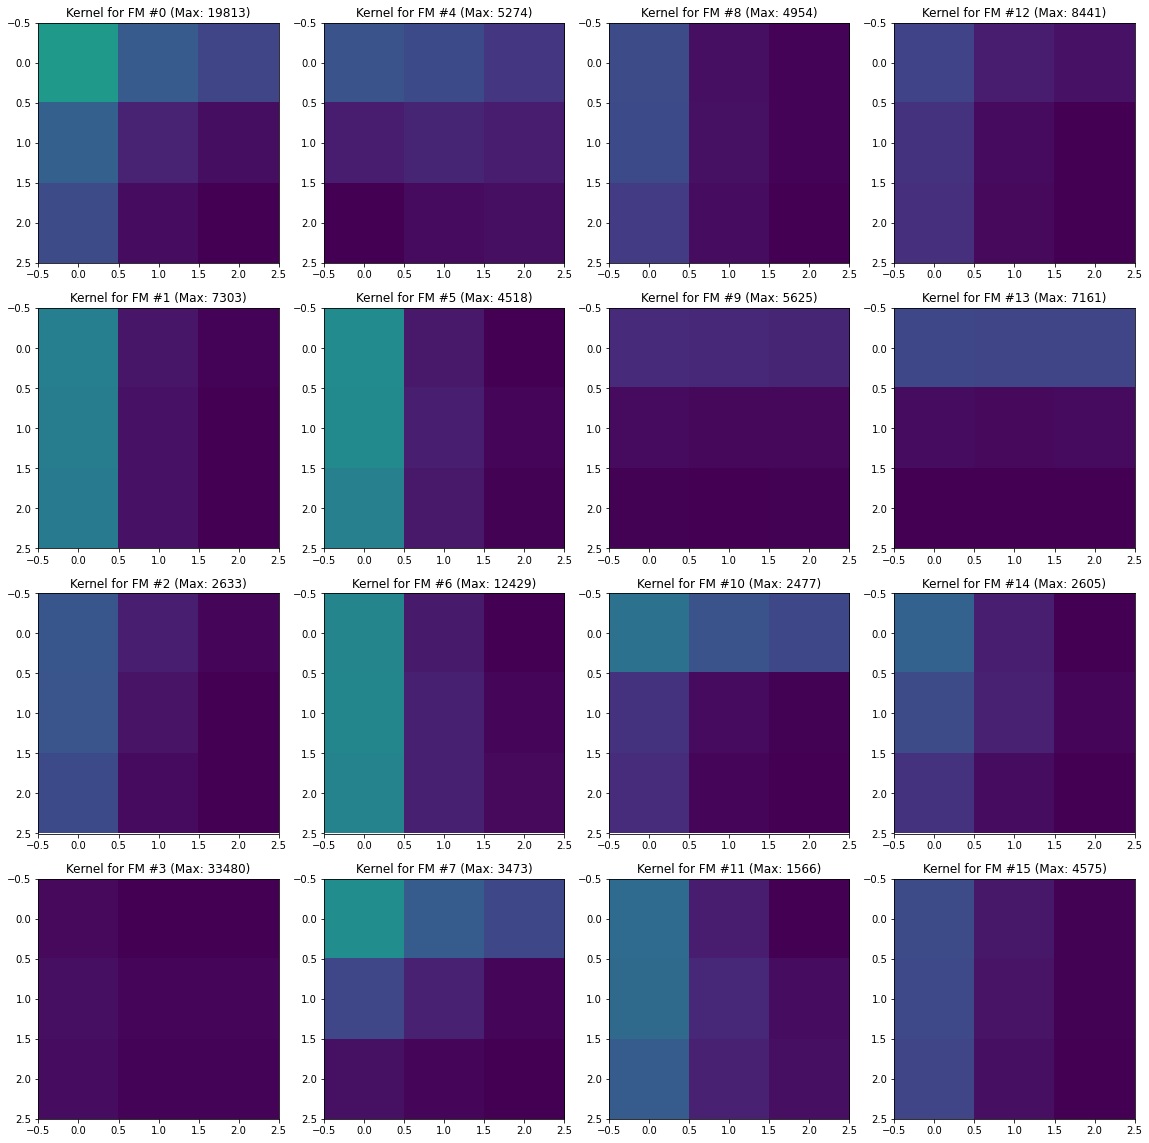

In [6]:
fig, axs = plt.subplots(4,4,figsize=(16,16))

for i in range(4):
    for j in range(4):
        axs[i,j].imshow(model.K[i+4*j, 0, :, :], vmax=np.max(model.K[i+4*j, :, :]))
        axs[i,j].set_title(f"Kernel for FM #{i+4*j} (Max: {int(np.max(model.K[i+4*j,:,:]))})")
plt.tight_layout()

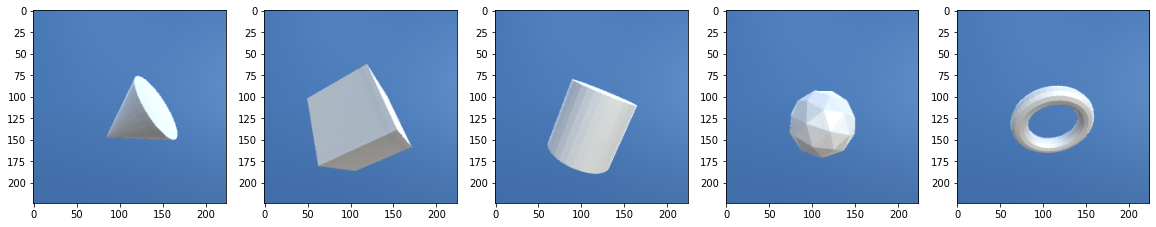

In [5]:
def plottable_image(img):
    return torch.swapaxes(torch.swapaxes(img[0,...], 0, 2), 0, 1).numpy().astype(int)

j = 500

num_objects = 5
fig, axs = plt.subplots(1, num_objects, figsize=(4*num_objects, 4))

for i in range(num_objects):
    idx = i*1024 + j
    
    img, _ = ds[idx]
    axs[i].imshow(plottable_image(img))
    
    

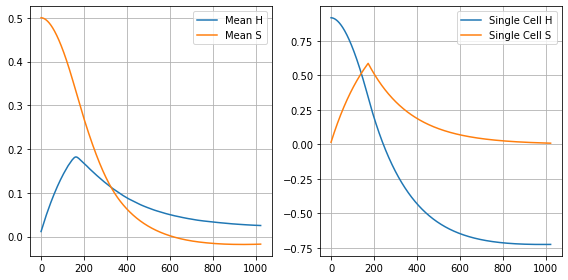

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(mean_h, label='Mean H')
axs[0].plot(mean_s, label='Mean S')
axs[0].grid(True)
axs[0].legend()
axs[1].plot(last_h, label='Single Cell H')
axs[1].plot(last_s, label='Single Cell S')
axs[1].grid(True)
axs[1].legend()
plt.tight_layout()

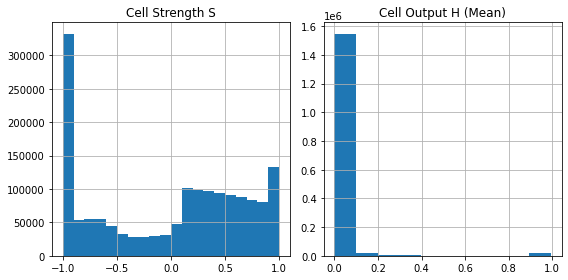

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].hist(model.S.cpu().detach().numpy().reshape(np.prod(model.S.shape)), bins=20)
#axs[0].set_yscale('log')
axs[0].grid(True)
axs[0].set_title('Cell Strength S')
axs[1].hist(model.H.cpu().detach().numpy().reshape(np.prod(model.H.shape)), bins=10)
#axs[1].set_yscale('log')
axs[1].grid(True)
axs[1].set_title('Cell Output H (Mean)')
plt.tight_layout()

In [52]:
model.G_d.shape

torch.Size([128, 56, 56])

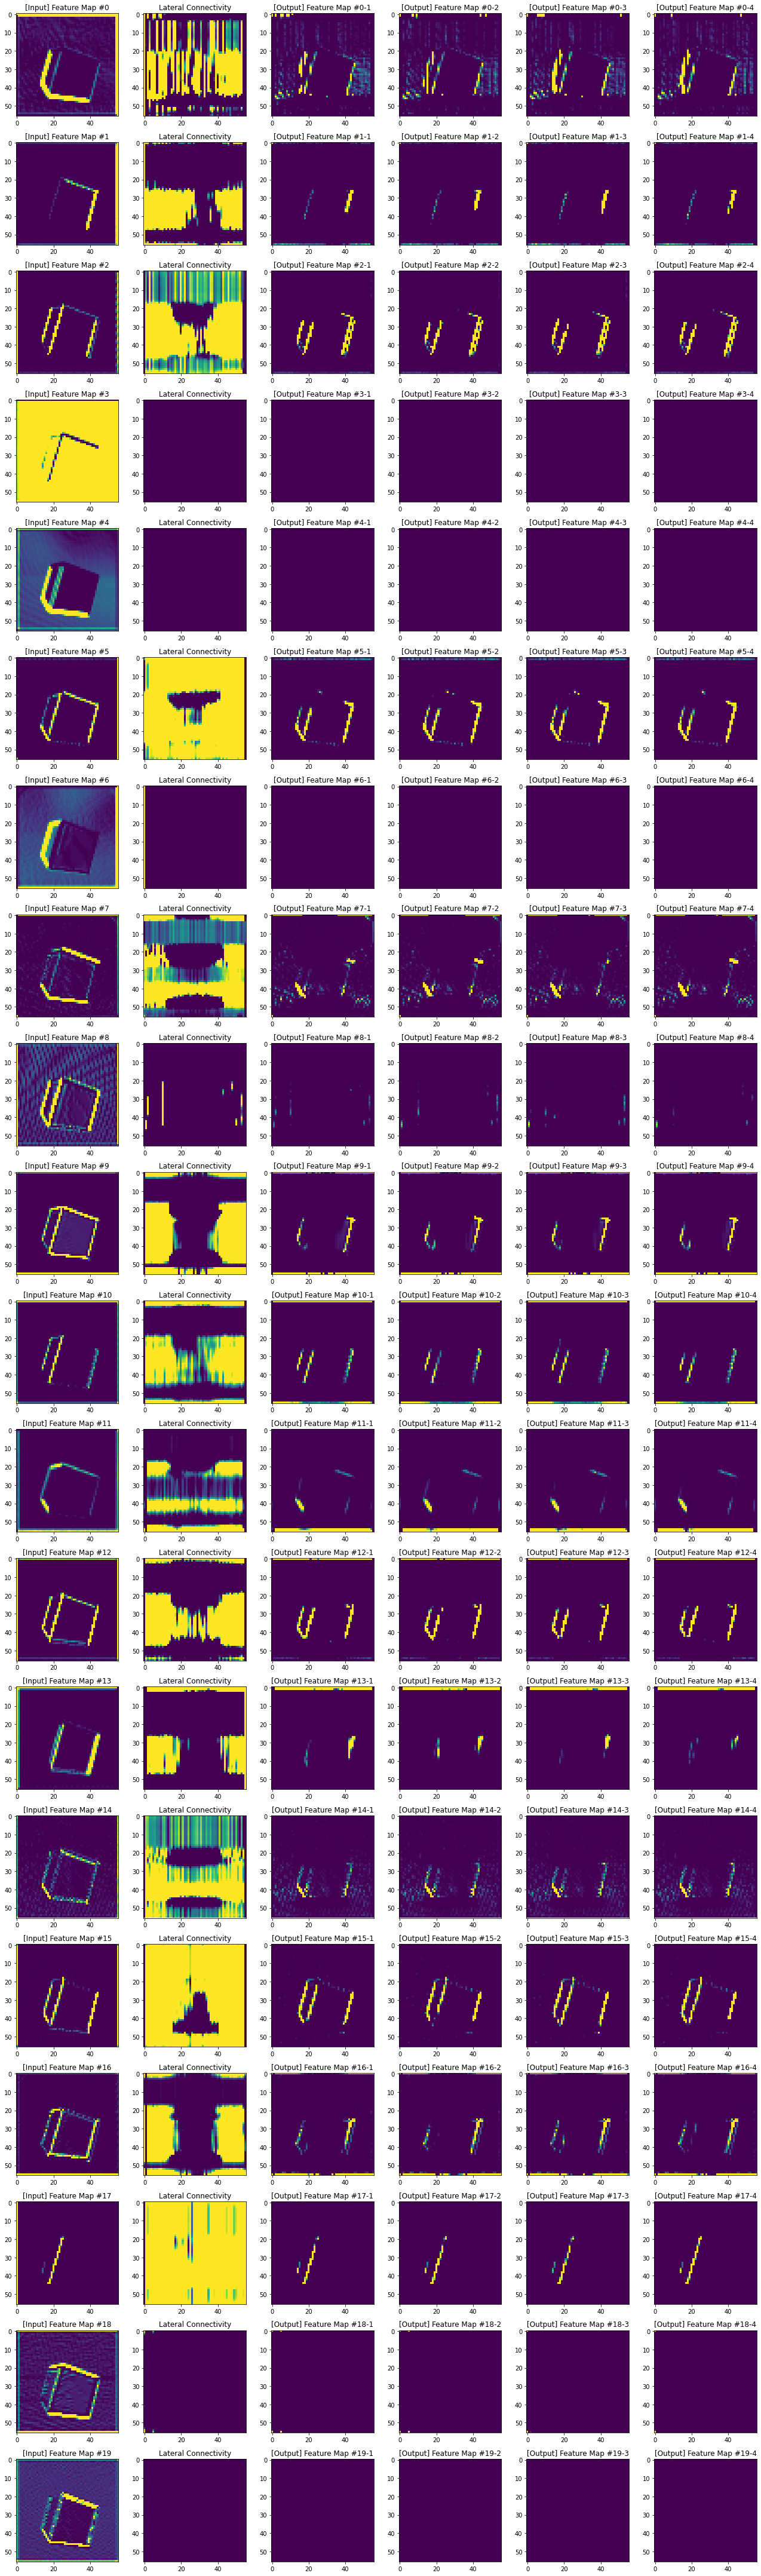

In [51]:
num_fm = 20
plot_size = 3

#feature_map_idx = np.sort(np.random.choice(model.O.shape[-3], num_fm, replace=False))
feature_map_idx = np.arange(num_fm)

fig, axs = plt.subplots(num_fm, 2 + model.num_output_repetitions, figsize=(plot_size*(2 + model.num_output_repetitions), plot_size*num_fm))
for i, fm_i in enumerate(feature_map_idx):
    axs[i][0].imshow(model.C[0, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
    axs[i][0].set_title(f"[Input] Feature Map #{fm_i}")
    
    axs[i][1].imshow(model.L[0, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
    axs[i][1].set_title(f"Lateral Connectivity")
    
    for n in range(model.num_output_repetitions):
        axs[i][2+n].imshow(model.O[n, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
        axs[i][2+n].set_title(f"[Output] Feature Map #{fm_i}-{n+1}")
    
plt.tight_layout()
